# 학습 목표
1. 단백질 구조 예측의 기초 개념(전통적 접근 vs. 딥러닝 기반 접근)을 이해한다.
2. Contact map이 무엇이며, 어떻게 계산하는지를 예시 코드를 통해 학습한다.
3. 간단한 딥러닝 모델(CNN 기반)을 통해 서열에서 Contact map을 예측하는 아이디어를 익힌다.



# 0. 환경 설정

In [ ]:
!pip install bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser

# 1. 단백질 구조 예측 이론
1.1 단백질 구조 예측의 전통적 접근
- Homology Modeling: 서열 상동성(유사성)이 높은 단백질 구조를 템플릿으로 이용.
- Threading(스레딩): 구조 라이브러리에 서열을 대입해 가장 근사한 fold를 찾음.
- Ab Initio (물리 기반): 에너지 최소화(분자 동역학, 몬테칼로)를 통해 구조 탐색.
이 전통적 접근들은 템플릿이 필요하거나 계산 비용이 크다는 단점이 존재.

1.2 딥러닝 기반 접근 (AlphaFold 이전)
- 2010년대 중반부터 공진화(Coevolution) 신호 기반 Contact map 예측에 딥러닝(CNN, RNN 등)이 사용됨.
- RaptorX-Contact, TASSER, Rosetta+딥러닝 등 여러 모델이 개발.
- 대체로 "서열(MSA) -> (CNN/RNN/ResNet) -> 2D Contact map 또는 거리행렬 -> 물리적 리파인"의 흐름.

1.3 Contact map이란?
- 단백질의 3D 구조를 2D 행렬로 나타낸 것.
- 행과 열은 각각 단백질 아미노산 인덱스를 의미하며,
  특정 임계 거리 이하로 가까우면 1(접촉), 멀면 0(비접촉)으로 표시.
- 3D 정보를 간접적으로 표현해주며, 딥러닝으로 예측하기도 쉬운 구조(2D 이미지 형태와 유사).

# 2. Contact map 계산 실습
실제 PDB 파일(1CRN 예시)에서 원자 좌표를 파싱하여,
  Cα 원자들 간 거리를 계산하고, 일정 임계값(threshold) 내에 있으면 접촉으로 간주하는
  Contact map을 생성해본다.
  
Biopython을 통해 PDB 파일을 파싱하는 기본 흐름:
1. PDBParser() 객체 생성
2. parser.get_structure("id", "1crn.pdb") 호출 -> Structure 객체 반환
3. 구조 객체에서 chain, residue, atom 정보를 순회
4. 각 residue의 원하는 원자(Cα 등) 좌표를 배열에 저장
5. 모든 쌍 간 유클리드 거리 계산 -> threshold 적용 -> contact map

In [ ]:
!wget https://files.rcsb.org/download/1CRN.pdb

--2025-03-14 06:59:38--  https://files.rcsb.org/download/1CRN.pdb
Resolving files.rcsb.org (files.rcsb.org)... 18.238.238.46, 18.238.238.113, 18.238.238.53, ...
Connecting to files.rcsb.org (files.rcsb.org)|18.238.238.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1CRN.pdb’

1CRN.pdb                [ <=>                ]  48.33K  --.-KB/s    in 0.03s   

2025-03-14 06:59:39 (1.39 MB/s) - ‘1CRN.pdb’ saved [49491]



In [ ]:
pdb_file = "1CRN.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure("1crn", pdb_file)

In [ ]:
# Cα 좌표만 뽑아서 리스트에 저장
coords = []
for model in structure:
    for chain in model:
        for residue in chain:
            # 일반적인 단백질 residue인지 확인 (HETATM 등 제외)
            if residue.get_id()[0] == " ":
                ca_atom = residue["CA"]  # CA 원자
                coords.append(ca_atom.coord)  # (x, y, z) numpy array

coords = np.array(coords)  # (L, 3), L = number of residues
print(f"Number of residues with CA atoms: {len(coords)}")

Number of residues with CA atoms: 46


In [ ]:
# 임의로 임계 거리(threshold) = 8.0 Å로 설정 (Cα 간 8Å 이내면 접촉으로 가정)
threshold = 8.0

diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]  # shape: (L, L, 3)
dist_matrix = np.linalg.norm(diff, axis=-1)  # shape: (L, L)

contact_map = (dist_matrix <= threshold).astype(int)

# 결과 출력
print("Distance matrix shape:", dist_matrix.shape)
print("Contact map shape:", contact_map.shape)

contact_map

Distance matrix shape: (46, 46)
Contact map shape: (46, 46)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1]])

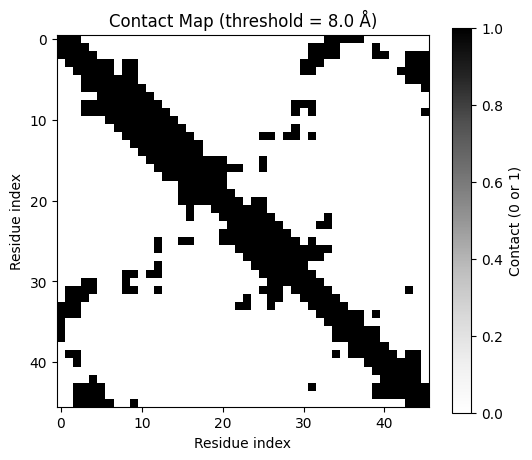

In [ ]:
# Contact map 시각화
plt.figure(figsize=(6, 5))
plt.imshow(contact_map, cmap='Greys')
plt.title(f"Contact Map (threshold = {threshold} Å)")
plt.xlabel("Residue index")
plt.ylabel("Residue index")
plt.colorbar(label="Contact (0 or 1)")
plt.show()

# 3. 서열에서 Contact map 예측 실습
- 서로 다른 여러 개의 소형 단백질 PDB 파일을 수집하여, 각각의 서열/좌표 → Contact map을 구한 뒤, 소규모 데이터셋으로 CNN을 학습해보기.
- 서로 다른 단백질의 길이가 달라 batch 학습이 어렵기 때문에, 여기서는 batch_size=1로 학습.
- 실제로는 길이 차이를 해결하기 위한 padding+masking 기법 등이 필요.


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser

In [ ]:
# PDB 다운로드
pdb_list = ["1CRN", "2CI2", "1STN"]
for pdb_id in pdb_list:
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    print(f"Downloading {pdb_id} from RCSB PDB...")
    os.system(f"wget {url}")

In [ ]:
# PDB 파싱 함수 만들기
three_to_int = {
    "ALA":0, "CYS":1, "ASP":2, "GLU":3, "PHE":4,
    "GLY":5, "HIS":6, "ILE":7, "LYS":8, "LEU":9,
    "MET":10,"ASN":11,"PRO":12,"GLN":13,"ARG":14,
    "SER":15,"THR":16,"VAL":17,"TRP":18,"TYR":19
}
def aa_to_int(res_name):
    return three_to_int.get(res_name, 20)  # 20=UNK

def parse_pdb_get_seq_coords(pdb_path):
    """
    Biopython을 이용해 PDB를 파싱하고,
    CA 좌표 및 아미노산 정수 시퀀스를 반환.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("temp", pdb_path)
    coords = []
    seq_idx= []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] == " ":  # 표준 Residue
                    if "CA" in residue:
                        coords.append(residue["CA"].coord) # (x,y,z)
                        aa_idx = aa_to_int(residue.get_resname())
                        seq_idx.append(aa_idx)
    coords = np.array(coords)
    seq_idx= np.array(seq_idx)
    return coords, seq_idx

In [ ]:
# Dataset 정의
class MultiPDBContactDataset(Dataset):
    """
    여러 PDB 파일의 (coords, seq)를 모아두고,
    각 coords에 random noise를 주어 contact map을 계산한 (seq, contact_map) 샘플을 생성.

    - pdb_files: ["1CRN.pdb", "2CI2.pdb", ...]
    - num_noise_per_pdb: 각 PDB별로 몇 개의 random-noise 샘플을 만들지?
    - threshold: contact map 임계 거리
    - noise_scale: 좌표 노이즈 표준편차
    """
    def __init__(self, pdb_files, num_noise_per_pdb=5, threshold=8.0, noise_scale=0.5):
        super().__init__()
        self.samples = []

        for pdbf in pdb_files:
            # 파싱
            coords, seq_idx = parse_pdb_get_seq_coords(pdbf)
            L = len(seq_idx)
            if L < 1:
                print(f"[Warning] {pdbf} has no CA coords? Skip.")
                continue

            for _ in range(num_noise_per_pdb):
                noisy_coords = coords + np.random.normal(scale=noise_scale, size=coords.shape)
                diff = noisy_coords[:, None, :] - noisy_coords[None, :, :]
                dist = np.linalg.norm(diff, axis=-1)   # (L,L)
                cmap = (dist <= threshold).astype(np.float32)
                # samples에 (seq_idx, cmap)을 저장
                self.samples.append((seq_idx.copy(), cmap))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, cm = self.samples[idx]
        seq_t = torch.LongTensor(seq)          # (L,)
        cm_t  = torch.FloatTensor(cm)          # (L,L)
        return seq_t, cm_t

In [ ]:
# 모델 정의 (서열→Contact map)
class SimpleContactNet(nn.Module):
    def __init__(self, num_aa=21, embed_dim=32, hidden=16):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_aa, embedding_dim=embed_dim)

        # 2D CNN
        self.conv1 = nn.Conv2d(embed_dim*2, hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden, hidden, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(hidden, 1, kernel_size=3, padding=1)

    def forward(self, seq):
        """
        seq shape: (batch=1, L)
        """
        # 임베딩: (1, L, embed_dim)
        x_embed = self.embedding(seq)

        # pair-wise feature
        # rep_i: (1, L, 1, embed_dim)-> (1,L,L,embed_dim)
        rep_i = x_embed.unsqueeze(2).expand(-1, -1, x_embed.size(1), -1)
        # rep_j: (1, 1, L, embed_dim)-> (1,L,L,embed_dim)
        rep_j = x_embed.unsqueeze(1).expand(-1, x_embed.size(1), -1, -1)

        pair_feat = torch.cat([rep_i, rep_j], dim=-1)  # (1, L, L, 2*embed_dim)
        pair_feat = pair_feat.permute(0,3,1,2)         # (1, 2*embed_dim, L, L)

        h = F.relu(self.conv1(pair_feat))
        h = F.relu(self.conv2(h))
        logits = self.conv_out(h)  # (1,1,L,L)
        return logits

In [ ]:
# 학습 루프 정의
def train_loop(model, loader, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lossfn = nn.BCEWithLogitsLoss()
    model.train()
    for e in range(epochs):
        total_loss=0.0
        for seq_t, cm_t in loader:
            # seq_t: (batch=1, L), cm_t: (batch=1, L, L)
            optimizer.zero_grad()
            logits = model(seq_t)  # (1,1,L,L)
            loss = lossfn(logits.squeeze(0).squeeze(0), cm_t.squeeze(0))
            # logits.squeeze(0).squeeze(0) → (L,L), cm_t.squeeze(0) → (L,L)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {e+1}/{epochs}, Loss = {total_loss/len(loader):.4f}")

Total samples in dataset: 15
Epoch 1/30, Loss = 0.5750
Epoch 2/30, Loss = 0.3752
Epoch 3/30, Loss = 0.3448
Epoch 4/30, Loss = 0.3330
Epoch 5/30, Loss = 0.3253
Epoch 6/30, Loss = 0.3165
Epoch 7/30, Loss = 0.3074
Epoch 8/30, Loss = 0.2986
Epoch 9/30, Loss = 0.2886
Epoch 10/30, Loss = 0.2780
Epoch 11/30, Loss = 0.2670
Epoch 12/30, Loss = 0.2564
Epoch 13/30, Loss = 0.2461
Epoch 14/30, Loss = 0.2366
Epoch 15/30, Loss = 0.2295
Epoch 16/30, Loss = 0.2209
Epoch 17/30, Loss = 0.2081
Epoch 18/30, Loss = 0.1944
Epoch 19/30, Loss = 0.1838
Epoch 20/30, Loss = 0.1747
Epoch 21/30, Loss = 0.1649
Epoch 22/30, Loss = 0.1584
Epoch 23/30, Loss = 0.1535
Epoch 24/30, Loss = 0.1564
Epoch 25/30, Loss = 0.1960
Epoch 26/30, Loss = 0.1609
Epoch 27/30, Loss = 0.1452
Epoch 28/30, Loss = 0.1361
Epoch 29/30, Loss = 0.1305
Epoch 30/30, Loss = 0.1266


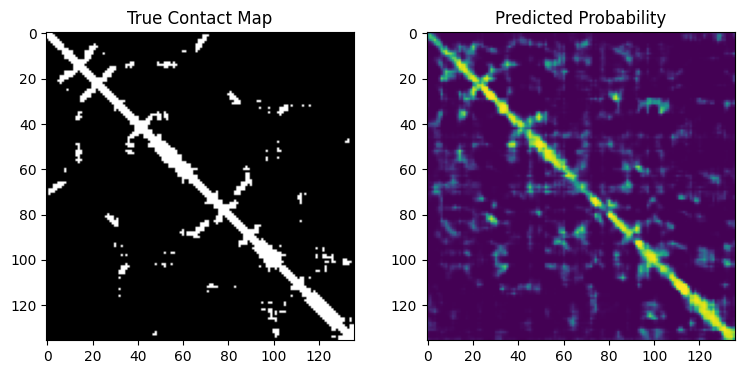

In [ ]:
# 1) 여러 PDB 데이터셋 구성
pdb_files = [f"{pid}.pdb" for pid in pdb_list]
dataset = MultiPDBContactDataset(
    pdb_files=pdb_files,
    num_noise_per_pdb=5,   # 각 PDB마다 5개 노이즈 샘플
    threshold=8.0,
    noise_scale=0.5
)
print(f"Total samples in dataset: {len(dataset)}")

# DataLoader (batch_size=1)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# 2) 모델 초기화
model = SimpleContactNet(num_aa=21, embed_dim=32, hidden=16)

# 3) 학습
train_loop(model, loader, epochs=30, lr=1e-3)

# 4) 임의의 샘플 결과 시각화
model.eval()
seq_t, cm_t = dataset[0]  # 첫 번째 샘플
with torch.no_grad():
    # 차원을 batch=1 형태로 맞춰 forward
    seq_in = seq_t.unsqueeze(0)  # (1, L)
    logits = model(seq_in)       # (1,1,L,L)
    pred_prob = torch.sigmoid(logits)[0,0]  # (L,L)

true_map = cm_t.numpy()
pred_map = pred_prob.numpy()

fig, axs = plt.subplots(1,2, figsize=(9,4))
axs[0].imshow(true_map, cmap='gray', vmin=0, vmax=1)
axs[0].set_title("True Contact Map")
axs[1].imshow(pred_map, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title("Predicted Probability")
plt.show()

# 4. 모델 검증

In [ ]:
def test_new_pdb(model, pdb_id, threshold=8.0):
    """
    1) CA coords & seq 파싱
    2) 실제 contact map 계산
    3) 모델 forward → 예측 확률
    4) 시각화
    """
    coords, seq_idx = parse_pdb_get_seq_coords(f"{pdb_id}.pdb")
    if len(seq_idx)==0:
        print(f"[{pdb_id}] No valid CA coords found.")
        return

    # 실제 contact map 계산
    diff = coords[:,None,:] - coords[None,:,:]
    dist = np.linalg.norm(diff, axis=-1)
    true_cm = (dist <= threshold).astype(np.float32)  # (L,L)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        seq_t = torch.LongTensor(seq_idx).unsqueeze(0)  # (1,L)
        logits = model(seq_t)                           # (1,1,L,L)
        pred_prob = torch.sigmoid(logits)[0,0].numpy()  # (L,L)

    # 시각화
    fig, axs = plt.subplots(1,2, figsize=(9,4))
    axs[0].imshow(true_cm, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"[{pdb_id}] True Contact Map")
    axs[1].imshow(pred_prob, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title(f"[{pdb_id}] Predicted Probability")
    plt.show()

In [ ]:
# PDB 다운로드
!wget https://files.rcsb.org/download/1AIE.pdb

--2025-03-14 07:45:59--  https://files.rcsb.org/download/1AIE.pdb
Resolving files.rcsb.org (files.rcsb.org)... 18.238.238.120, 18.238.238.53, 18.238.238.113, ...
Connecting to files.rcsb.org (files.rcsb.org)|18.238.238.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1AIE.pdb’

1AIE.pdb                [ <=>                ]  53.16K  --.-KB/s    in 0.07s   

2025-03-14 07:46:00 (769 KB/s) - ‘1AIE.pdb’ saved [54432]



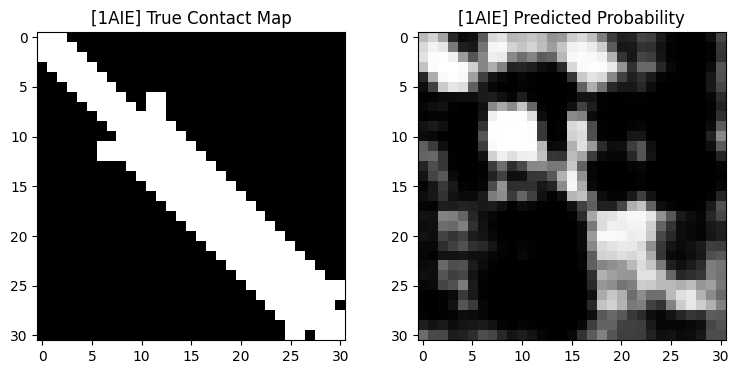

In [ ]:
test_new_pdb(model, '1AIE')